In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#This is an analysis of the K2 data for Neptune
#
#Data are from Rowe et al. 2017 
#  https://ui.adsabs.harvard.edu/?#abs/2017AJ....153..149R
#See Simon et al. 2016 for a published analysis and physical interpreatin
# http://adsabs.harvard.edu/abs/2016ApJ...817..162S


In [3]:
from astropy.table import Table
t = Table.read('K2Neptune_votable.vot')
t

BJD,Flux,e_Flux
d,,
float64,float32,float32
16.40017501,-0.00317,0.00036
16.40085596,-0.00292,0.00036
16.40153700,-0.00270,0.00036
16.40221805,-0.00265,0.00036
16.40289919,-0.00266,0.00036
16.40358023,-0.00245,0.00036
16.40426138,-0.00238,0.00036
16.40494242,-0.00241,0.00036


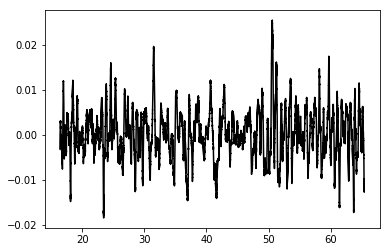

In [4]:
plt.plot(t['BJD'],t['Flux'],'k-')


In [5]:
idataset_size=t['BJD'].size
print(idataset_size)

68481


(10, 25)

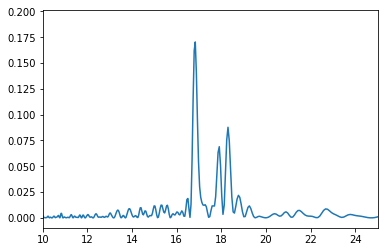

In [6]:
#make Lomb-Scargle
# See http://docs.astropy.org/en/stable/stats/lombscargle.html
from astropy.stats import LombScargle
frequency, power = LombScargle(t['BJD'], t['Flux'],t['e_Flux']).autopower()
# should change units properly instead of just multiplying...
period_hr=24.0/frequency
plt.plot(period_hr,power)
plt.xlim(10,25)
 

(0, 5)

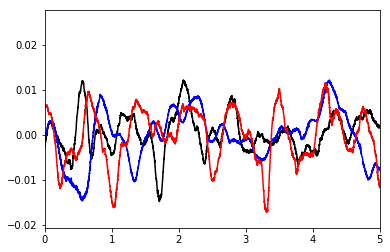

In [7]:
plt.plot(t['BJD']-16.4,t['Flux'],'k-',t['BJD']-36.4,t['Flux'],'b-',t['BJD']-60.4,t['Flux'],'r-')
plt.xlim(0,5)
#This should look something like Figure 1 of Simon et al. 

In [8]:
#Let's exoplore some of the tools from Dan Foreman-Mackey's (DFM) exoplanet toolchest
# In particular, the stellar variability model using Gaussian processes
# Personally I first saw this in Ruth Angus's papers and seminars so it should be cited too.
#
# see https://exoplanet.dfm.io/en/stable/tutorials/stellar-variability/
#
# However, it is a single period model when we know this is multi-period. Let's see
# what happens anyway
#
# First, import the stuff
import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt



In [9]:
# LEt's rename arrays and manipulate as in the tutorial.  Otherwise I get an error, either
# due to the units or something that is infinite/not-a-number.
xall=t['BJD']
yall=t['Flux']
yerrall=t['e_Flux']
m = np.isfinite(xall) & np.isfinite(yall)

xall = np.ascontiguousarray(xall[m], dtype=np.float64)
yall = np.ascontiguousarray(yall[m], dtype=np.float64)
yerrall = np.ascontiguousarray(yerrall[m], dtype=np.float64)


In [10]:
#now let us choose random subset of 1/30 the data.  
ismallsize=idataset_size//30
#Use method from stack overflow 
#https://stackoverflow.com/questions/47941079/can-i-make-random-mask-with-numpy?rq=1
amask = np.full(idataset_size, False)
amask[:ismallsize] = True
np.random.shuffle(amask)
#
x=xall[amask]
y=yall[amask]
yerr=yerrall[amask]
#

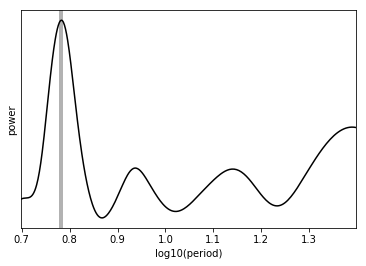

In [11]:

# Let's try the DFM exoplanet periodogram as in the tutorial... 
#   even though we did our own above!

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=5.0, max_period=25.0,
    samples_per_peak=50)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(peak["period"]), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power");



Analyzing all the data does not make so much sense. We have high signal-to-noise observations sampled every minute for rotation period of ~16-20 hours; the values are very tightly constrained! It might be illustrative to only analyze a fraction like 1/100 of the data.  


(30, 40)

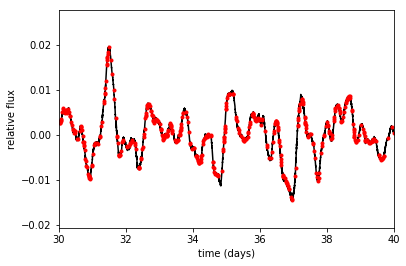

In [12]:
plt.plot(xall,yall,'k-',x,y,'r.')
plt.xlabel("time (days)")
plt.ylabel("relative flux");
plt.xlim(30,40)

In [13]:
with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)

    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr)), sd=5.0)

    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
    logperiod = pm.Normal("logperiod", mu=np.log(peak["period"]), sd=5.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = pm.Uniform("mix", lower=0, upper=1.0)

    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))

    # Set up the Gaussian Process model
    kernel = xo.gp.terms.RotationTerm(
        log_amp=logamp,
        period=period,
        log_Q0=logQ0,
        log_deltaQ=logdeltaQ,
        mix=mix
    )
    gp = xo.gp.GP(kernel, x, yerr**2 + tt.exp(logs2), J=4)

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    pm.Potential("loglike", gp.log_likelihood(y - mean))

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())

    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)


optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp', 'logs2', 'mean']
message: Desired error not necessarily achieved due to precision loss.
logp: -18822.139598711172 -> 13375.24859547844


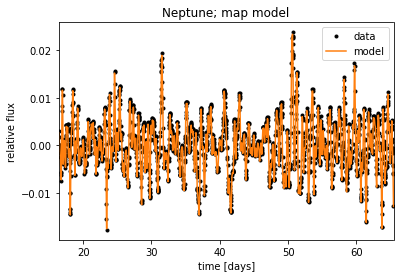

In [14]:
# plot as in tutorial 
plt.plot(x, y, "k.", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.title("Neptune; map model");


(30, 35)

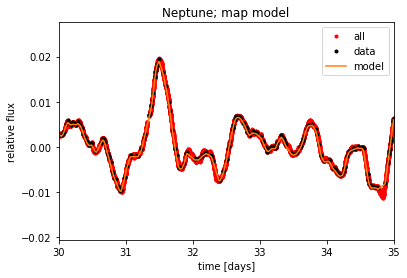

In [15]:
# plot as in tutorial but with everything and just a few days
plt.plot(xall, yall, "r.", label="all")
plt.plot(x, y, "k.", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.title("Neptune; map model");
plt.xlim(30,35)

In [16]:
#citations
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:exoplanet, exoplanet:foremanmackey17,
exoplanet:foremanmackey18, exoplanet:pymc3, exoplanet:theano}.


In [17]:
# the bibtext entry
print("\n".join(bib.splitlines()[:10]) + "\n...")



@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...


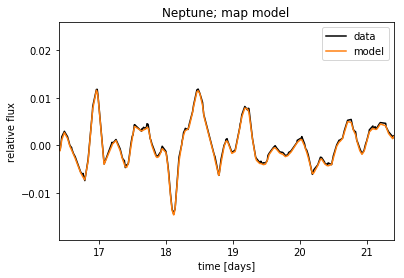

In [18]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(16.4, 21.4)
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.title("Neptune; map model");


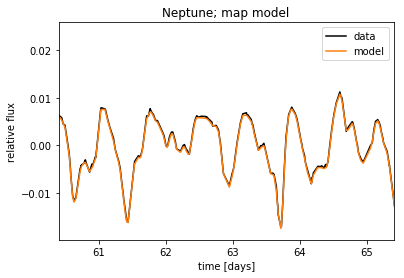

In [19]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(60.4, 65.4)
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.title("Neptune; map model");


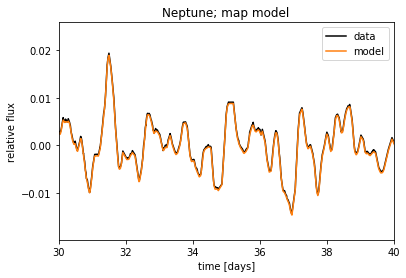

In [20]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(30, 40)
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.title("Neptune; map model");

In [21]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(finish=200)
with model:
    sampler.tune(tune=2000, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=2000)


Sampling 2 chains: 100%|██████████| 404/404 [00:22<00:00, 15.89draws/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logs2, mean]
Sampling 2 chains: 100%|██████████| 4000/4000 [02:04<00:00, 32.10draws/s]
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8287701701839498, but should be close to 0.9. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8334677964231837, but should be close to 0.9. Try to increase the number of tuning steps.


In [22]:
pm.summary(trace, varnames=["mix", "logdeltaQ", "logQ0", "logperiod", "logamp", "logs2", "mean"])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mix,0.230993,0.045394,0.000860,0.147139,0.321722,2612.005868,0.999760
logdeltaQ,-7.603016,5.464598,0.147831,-18.330194,-0.007738,1171.660749,1.001925
logQ0,0.420208,0.123900,0.002616,0.161805,0.655011,2137.401684,0.999792
logperiod,-0.293223,0.027315,0.000542,-0.345831,-0.239616,2149.048249,1.000904
logamp,-10.579743,0.114611,0.002343,-10.809093,-10.354813,2208.745652,1.000516
logs2,-24.483531,2.202977,0.047848,-28.845733,-20.848145,2030.105687,1.002574
mean,0.000283,0.000252,0.000005,-0.000186,0.000807,2183.689020,0.999951


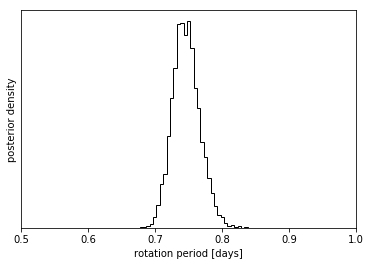

In [25]:
period_samples = trace["period"]
bins = np.linspace(.5, 1.0, 100)
plt.hist(period_samples, bins, histtype="step", color="k")
plt.yticks([])
plt.xlim(bins.min(), bins.max())
plt.xlabel("rotation period [days]")
plt.ylabel("posterior density");

Conclusion: The Gaussian Process with a periodic kernel does a great job of describing the data, even with a small subset of the data. However, this flexibility lets it use a relatively uncertain period (0.7-0.8 days, i.e. 17-19 hours centered on the strongest period).  The rich K2 dataset lets us see in the full periodogram (as Simon et al. discussed) that there are multiple rotation periods due to wind. 